# Dependencies

In [ ]:
import numpy as np
import torch
import torchvision.transforms as transforms
import lightning as L
from pytorch_lightning.callbacks import Callback
from torchvision.models import vit_b_16, vit_b_32 # pretrained model
import torchmetrics
import cv2
import optuna
import joblib
import albumentations as A

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Modify the Python Path in Notebook

In [ ]:
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../src")))

In [ ]:
import datasets as btd
from transforms import CropImgTransform
from utils import show_image_grid
from config import TEST_DATA_PATH, TRAIN_DATA_PATH
from augmentations import augment_data, show_augmentations

# Data Augmentation

| **Augmentation**               | **Why Use It?**                                                                                           |
|---------------------------------|----------------------------------------------------------------------------------------------------------|
| **Rotate**                     | Simulates orientation differences.                                                                       |
| **Horizontal**				 | Increases diversity while retaining symmetry.                                                           |
| **Random Crop**                | Focuses on smaller regions of interest.                                                                 |
| **Elastic Transform**          | Introduces non-rigid variations.                                                                        |
| **Brightness/Contrast Adjustment** | Mimics scanner variability.                                                                             |
| **CLAHE**                      | Enhances local contrast, highlighting subtle features.                                                  |
| **Gaussian Noise**             | Simulates noisy scans.                                                                                  |
| **Compression**                | Mimics lossy storage artifacts.                                                                         |
| **Coarse Dropout**             | Simulates signal loss or occluded areas.                                                                |


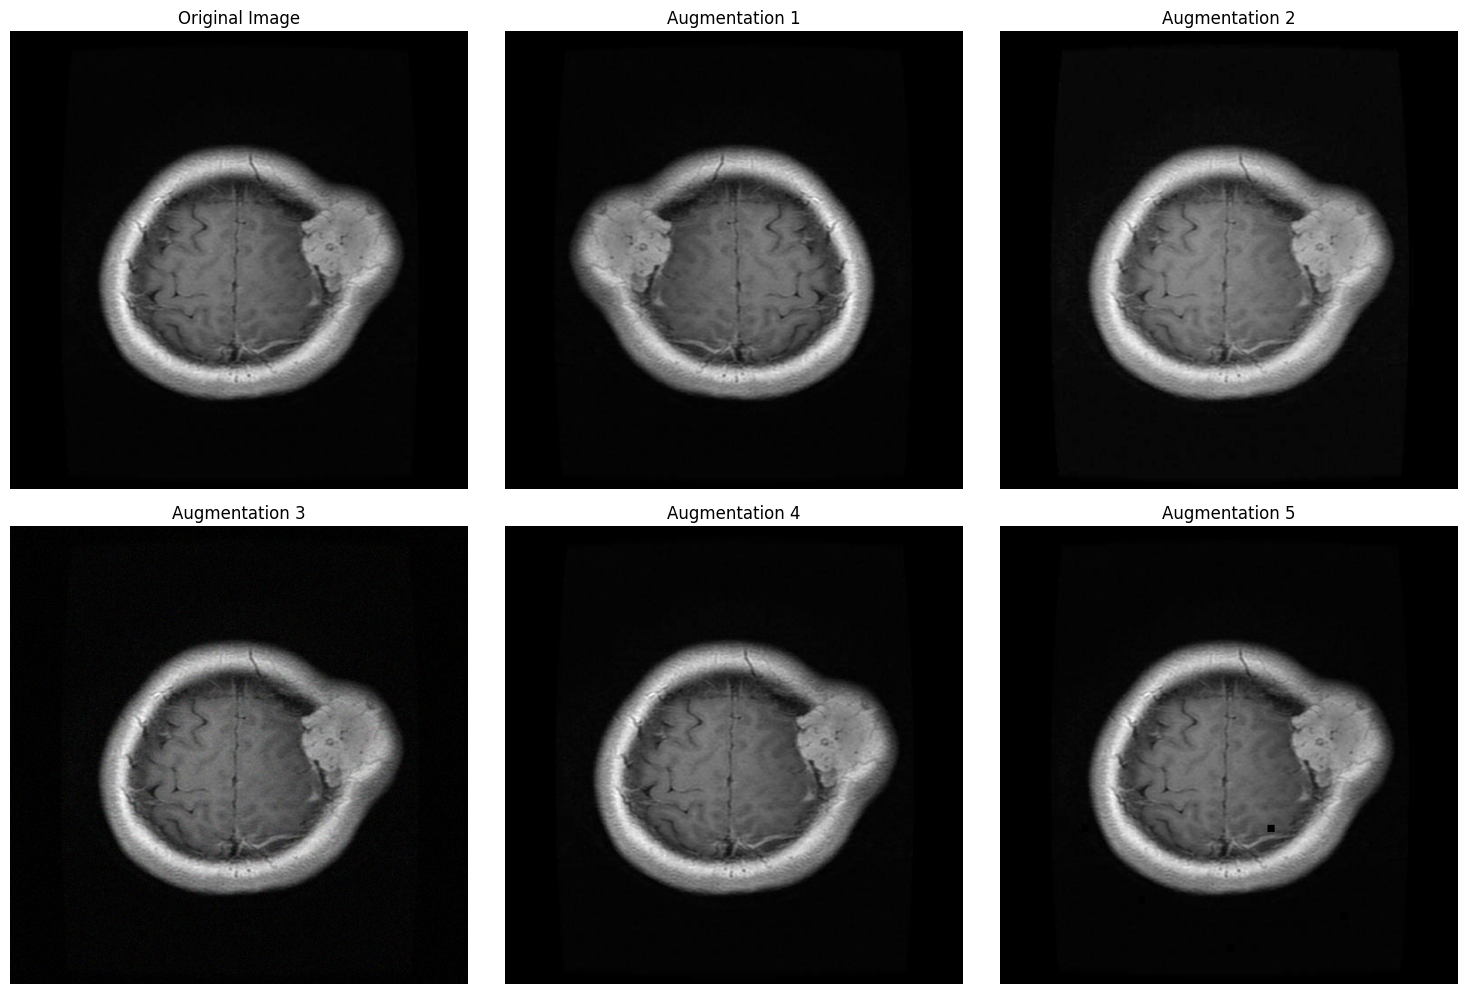

In [ ]:
augmentations = A.Compose([
    # Geometric transformations
    A.HorizontalFlip(p=0.5),  # Random horizontal flip

	# intensity and contrast transformations
    A.RandomGamma(p=.5),  # Random gamma adjustment for exposure variance

	# Noise and artifacts
    A.GaussNoise(p=.5),  # Simulates random noise in the image from the scanning process
    A.ImageCompression(quality_range=(60, 95), p=0.5),  # Simulates image compression artifacts
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.5),  # Simulates missing parts of the image
])

train_dataset = btd.BrainTumorDataset(TRAIN_DATA_PATH)
show_augmentations(train_dataset[0][0], augmentations)

In [ ]:
augment_data(augmentations=augmentations,
                 file_path=TRAIN_DATA_PATH,
                 num_augmentations=2,
                 overwrite=True)

Removed 0 existing augmented images.


Processing images in /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training/: 0it [00:00, ?it/s]


Added 0 augmented images in /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training/.


Processing images in /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training/meningioma: 100%|██████████| 1339/1339 [00:49<00:00, 27.27it/s]


Added 2678 augmented images in /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training/meningioma.


Processing images in /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training/glioma: 100%|██████████| 1321/1321 [00:44<00:00, 29.42it/s]


Added 2642 augmented images in /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training/glioma.


Processing images in /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training/pituitary: 100%|██████████| 1457/1457 [00:49<00:00, 29.38it/s]


Added 2914 augmented images in /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training/pituitary.


Processing images in /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training/notumor: 100%|██████████| 1595/1595 [00:28<00:00, 55.87it/s]

Added 3190 augmented images in /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training/notumor.


# Setup Data

In [18]:
# Define the transformation for the images
transform = transforms.Compose([
	transforms.Grayscale(num_output_channels=3),   # convert to 3 channels
	transforms.Resize((224, 224)),                 # resize to 224x224
	transforms.ToTensor(),
])

# Load your datasets with the defined transformations
train_dataset = btd.BrainTumorDataset(TRAIN_DATA_PATH, transform=transform)
test_dataset = btd.BrainTumorDataset(TEST_DATA_PATH, transform=transform)

val_size = len(test_dataset) // 2
test_size = len(test_dataset) - val_size
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [test_size, val_size])

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_dataset), len(test_dataset), len(val_dataset)

(17136, 656, 655)

# Setup Classifier

In [ ]:
# Define the PyTorch Lightning Module
class BrainTumorClassifier(L.LightningModule):
	def __init__(self,
			  learning_rate=1e-3,
			  patch_size=16,
        batch_size=None,
			  pretrained_weights = "IMAGENET1K_V1"):
		super().__init__()
		# Initialize the model with the pre-trained ViT
		if patch_size == 16:
			self.model = vit_b_16(weights=pretrained_weights)
		elif patch_size == 32:
			self.model = vit_b_32(weights=pretrained_weights)

		self.model.heads = torch.nn.Linear(self.model.hidden_dim, 4)  # Modify for 4 classes

		# Define loss function and learning rate
		self.criterion = torch.nn.CrossEntropyLoss()
		self.learning_rate = learning_rate

		# Initialize accuracy metric for logging
		self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4)
		self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4)

		self.attention_maps = {}  # To store attention maps

	def forward(self, x):
		return self.model(x)

	def training_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
		self.train_accuracy(outputs, labels)
		self.log('train_acc', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True)

		return loss

	def validation_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('val_loss', loss, on_epoch=True, prog_bar=True)
		self.val_accuracy(outputs, labels)
		self.log('val_acc', self.val_accuracy, on_epoch=True, prog_bar=True)

		return loss

	def test_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('test_loss', loss, on_epoch=True, prog_bar=True)
		self.val_accuracy(outputs, labels)
		self.log('test_acc', self.val_accuracy, on_epoch=True, prog_bar=True)

		self.log_attention_maps(inputs, labels)  # Save attention maps

		return loss

	def configure_optimizers(self):
		return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

	def register_attention_hooks(self):
		"""Register hooks to capture attention maps."""
		self.attention_maps.clear()  # Reset attention maps

		def hook_fn(module, input, output, module_name):
			module_name = module_name.split(".")[2]  # Get the layer name

			q, k, _ = input
			self.attention_maps[module_name] = torch.nn.functional.softmax(q @ k.transpose(-2, -1))  # Save attention map

		# Register hooks on all MultiheadAttention layers
		for i, module in self.model.named_modules():
			if isinstance(module, torch.nn.MultiheadAttention):
				module.register_forward_hook(lambda module, input, output, module_name=i: hook_fn(module, input, output, module_name))

	def on_test_start(self):
		# Register the hook to each multi-head attention layer before testing
		self.register_attention_hooks()

	def log_attention_maps(self, inputs, labels):
			"""Log attention maps overlaid on the original image using Lightning's logger."""
			batch_size = inputs.size(0)
			for i in range(batch_size):
				average_attention_map = None
				num_layers = len(self.attention_maps)
				for _, attention in self.attention_maps.items():
					# Get the attention map for the first image in the batch
					attention_map = attention[i]  # Shape: [num_tokens, embedding_size]

					# Compute cosine similarity between class token and patches
					class_token_embedding = attention_map[0, :]  # Shape: (embedding_size)
					num_patches_side = int((attention_map.size(0) - 1) ** 0.5)
					attention_map = class_token_embedding[1:].view(num_patches_side, num_patches_side, -1).clone()

					# Accumulate attention maps
					average_attention_map += attention_map

				average_attention_map = average_attention_map / num_layers
				average_attention_map = average_attention_map.cpu().detach().numpy()
				average_attention_map = cv2.resize(average_attention_map, (inputs.size(2), inputs.size(3)))
				heatmap = cv2.applyColorMap(np.uint8(255 * average_attention_map), cv2.COLORMAP_JET)

				# Overlay the heatmap on the original image
				image = inputs[i].cpu().numpy().transpose(1, 2, 0)
				image = (image*255).astype(np.uint8)
				overlayed_image = cv2.addWeighted(image, 0.8, heatmap, 0.4, 0)

				# add class label
				label = labels[i].item()
				label = train_dataset.idx_to_class[label]
				cv2.putText(overlayed_image, f"Class: {label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

				# convert to chw
				overlayed_image = overlayed_image.transpose(2, 0, 1)

				# log to tensorboard
				self.logger.experiment.add_image(f'attention_map/image_{i}', overlayed_image, self.current_epoch)


# Training (Without Optuna)

In [ ]:
# Train the model
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [ ]:
# Test the model
trainer.test(model, dataloaders=test_loader)

# Training (With Optuna)
Based on [this guide](https://medium.com/swlh/optuna-hyperparameter-optimization-in-pytorch-9ab5a5a39e77)

In [ ]:
# Define the objective function for Optuna (the function to optimize)
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
    patch_size = trial.suggest_categorical('patch_size', [16])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Create the model and data module with suggested hyperparameters
    model = BrainTumorClassifier(learning_rate=learning_rate,
                                 patch_size=patch_size,
                                 batch_size=batch_size)

	# Define callbacks
    checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
		monitor="val_loss",                     # Monitor validation loss
		mode = "min",                           # mode for monitored metric
		dirpath="checkpoints/",                   # Directory to save checkpoints
		filename="epoch-{epoch:02d}-val_loss-{val_loss:.2f}",  # Naming pattern
		save_top_k=-1,                          # Save all checkpoints
		every_n_epochs=1,                       # Save at every epoch
	)

    early_stopping_callback = L.pytorch.callbacks.EarlyStopping(
		monitor="val_loss",                     # Metric to monitor
		patience=5,                             # Stop training if no improvement for 5 epochs
		mode="min",                             # Stop when `val_loss` stops decreasing
	)

    logger = L.pytorch.loggers.TensorBoardLogger("logs", name="vit_pretrained")

    # Define the PyTorch Lightning Trainer
    trainer = L.Trainer(
        max_epochs=20,
        accelerator="auto",
        logger=logger,
        callbacks=[early_stopping_callback],
    )

    # Train the model
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

    # save the model
    trainer.save_checkpoint(f"vit_pretrained_{trial.number}.ckpt")

    # Evaluate the model
    val_loss = trainer.callback_metrics["val_loss"].item()

    # report intermediate objective value
    trial.report(val_loss, step=trainer.current_epoch)

    # Handle pruning based on the intermediate value
    if trial.should_prune():
        raise optuna.TrialPruned()

    return val_loss

In [ ]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction="minimize", study_name="vit_pretrained")
study.optimize(objective, n_trials=12, show_progress_bar=True, n_jobs=3)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

In [ ]:
import joblib # Save the study
import time

now = time.strftime("%Y-%m-%d-%H-%M")
study_name = f"vit_pretrained_study_{now}.pkl"
joblib.dump(study, study_name)